# Testing Tenor Log Mel Spectrogram with Convolutional Neural Network

Here we test a convolutional neural network on log Mel spectrogram data extracted from our WAV samles. Each log Mel spectrogram has 96 x 96 = 9,216 features, where 96 is the number of frequency bands, and 96 is the number of time slices (collections of 2,297 raw samples). So this is a lot of data.

Upstream from this notebook we extracted these features and saved them as pickles, then we read all the pickles and aggregated them into a Pandas DataFrame, again saved as a pickle. Finally, with the imported `_tenor_lms` (below) we read from this pickle, filter and reshape the data as needed, and then we scale data using `sklearn.preprocessing.StandardScaler`. At this point, data are ready to read into our notebook.

In this notebook we define, train, and test a CNN with these log Mel spectrogram data as input.

In [33]:
import os
import time

import pandas as pd
import matplotlib.pyplot as plt
from keras.callbacks import TensorBoard, EarlyStopping
from keras.models import Sequential
from keras.layers import Dense, Flatten, Dropout, \
    Conv2D, MaxPooling2D, AveragePooling2D, LeakyReLU
from keras.metrics import AUC, Recall
from keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from _common import NUM_LABEL_COLS, RANDOM_SEED
from _tenor_lmsc import TEST_SIZE, VALIDATION_SIZE, \
    BANDS, TIME_SLICES, master, lmss, data, target
# Note that records are read from pickle, selected, filtered,
# and scaled with `sklearn.preprocessing.StandardScaler` 
# in `_tenor_lmsc.py`.

In [3]:
x_train, x_test, y_train, y_test = \
     train_test_split(data, target,
                      test_size=TEST_SIZE,
                      random_state=RANDOM_SEED)

In [4]:
# Reshape for input to 2D convolutional layer
x_train = x_train.reshape(x_train.shape[0], BANDS, TIME_SLICES, 1)
x_test = x_test.reshape(x_test.shape[0], BANDS, TIME_SLICES, 1)

# Train the CNN
This may take between 5 and 7 minutes per epoch

In [50]:
# Model F best performance
# @ 12 Epochs
# Recall: 95.59
# Accuracy: 91.96

# Model G

In [44]:
NUM_EPOCHS = 24
BATCH_SIZE = 32
INPUT_SHAPE = (BANDS, TIME_SLICES, 1)

# See: https://keras.io/api/callbacks/early_stopping/
early_stopping = EarlyStopping(monitor='val_recall', patience=4)

model = Sequential()
model.add(Conv2D(128, kernel_size=(2, 2), input_shape=INPUT_SHAPE))
model.add(LeakyReLU(alpha=0.1))
model.add(MaxPooling2D(pool_size=(2, 2)))  
model.add(Conv2D(128, kernel_size=(2, 2)))
model.add(LeakyReLU(alpha=0.1))
model.add(MaxPooling2D(pool_size=(2, 2)))  
model.add(Conv2D(128, kernel_size=(3, 3)))
model.add(LeakyReLU(alpha=0.1))  
model.add(MaxPooling2D(pool_size=(2, 2)))  
model.add(Conv2D(128, kernel_size=(3, 3)))
model.add(LeakyReLU(alpha=0.1))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128))
model.add(LeakyReLU(alpha=0.1))
model.add(Dropout(0.25))
model.add(Dense(64))
model.add(LeakyReLU(alpha=0.1))
model.add(Dropout(0.25))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', 
              metrics=[Recall(name='recall'), 'accuracy'])  # , AUC(name='auc')
history = model.fit(x_train, y_train, epochs=NUM_EPOCHS, 
                    batch_size=BATCH_SIZE, 
                    validation_split=VALIDATION_SIZE,
                    callbacks=[early_stopping])  # tensorboard_cb, 

Train on 3620 samples, validate on 906 samples
Epoch 1/24
3620/3620 [==============================] - 118s 33ms/step - loss: 0.4833 - recall: 0.7627 - accuracy: 0.7738 - val_loss: 0.3206 - val_recall: 0.9220 - val_accuracy: 0.8940
Epoch 2/24
3620/3620 [==============================] - 116s 32ms/step - loss: 0.3254 - recall: 0.8605 - accuracy: 0.8787 - val_loss: 0.2038 - val_recall: 0.9363 - val_accuracy: 0.9294
Epoch 3/24
3620/3620 [==============================] - 116s 32ms/step - loss: 0.2503 - recall: 0.9091 - accuracy: 0.9080 - val_loss: 0.1992 - val_recall: 0.9651 - val_accuracy: 0.9338
Epoch 4/24
3620/3620 [==============================] - 116s 32ms/step - loss: 0.2223 - recall: 0.9197 - accuracy: 0.9169 - val_loss: 0.2224 - val_recall: 0.9713 - val_accuracy: 0.9338
Epoch 5/24
3620/3620 [==============================] - 116s 32ms/step - loss: 0.1835 - recall: 0.9392 - accuracy: 0.9307 - val_loss: 0.1839 - val_recall: 0.9466 - val_accuracy: 0.9316


In [45]:
loss, recall, accuracy = model.evaluate(x_test, y_test)
print('Recall: %.2f' % (recall * 100))
print('Accuracy: %.2f' % (accuracy * 100))
# Recall: 95.59
# Accuracy: 93.64

1132/1132 [==============================] - 10s 8ms/step
Recall: 95.59
Accuracy: 93.64


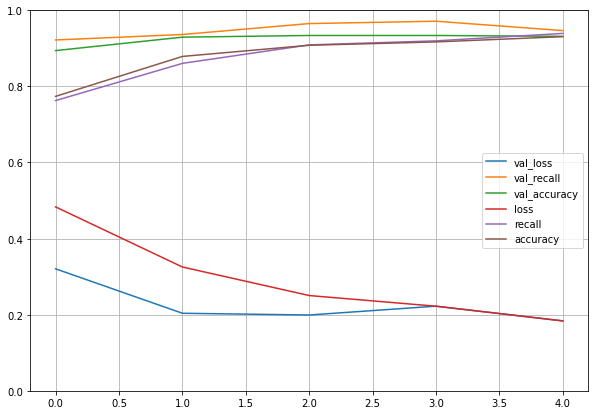

In [46]:
# history is a keras.callbacks.callbacks.History object
pd.DataFrame(history.history).plot(figsize=(10, 7))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()

In [47]:
model.summary()

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_38 (Conv2D)           (None, 95, 95, 128)       640       
_________________________________________________________________
leaky_re_lu_19 (LeakyReLU)   (None, 95, 95, 128)       0         
_________________________________________________________________
max_pooling2d_29 (MaxPooling (None, 47, 47, 128)       0         
_________________________________________________________________
conv2d_39 (Conv2D)           (None, 46, 46, 128)       65664     
_________________________________________________________________
leaky_re_lu_20 (LeakyReLU)   (None, 46, 46, 128)       0         
_________________________________________________________________
max_pooling2d_30 (MaxPooling (None, 23, 23, 128)       0         
_________________________________________________________________
conv2d_40 (Conv2D)           (None, 21, 21, 128)     

In [48]:
model.save('./keras_models/tenor_cnn/tenor_cnn_G.h5')

# Model H

In [49]:
NUM_EPOCHS = 24
BATCH_SIZE = 32
INPUT_SHAPE = (BANDS, TIME_SLICES, 1)

# See: https://keras.io/api/callbacks/early_stopping/
early_stopping = EarlyStopping(monitor='val_recall', patience=4)

model = Sequential()
model.add(Conv2D(128, kernel_size=(2, 2), input_shape=INPUT_SHAPE))
model.add(LeakyReLU(alpha=0.1))
model.add(MaxPooling2D(pool_size=(2, 2)))  
model.add(Conv2D(128, kernel_size=(2, 2)))
model.add(LeakyReLU(alpha=0.1))
model.add(MaxPooling2D(pool_size=(2, 2)))  
model.add(Conv2D(128, kernel_size=(3, 3)))
model.add(LeakyReLU(alpha=0.1))  
model.add(MaxPooling2D(pool_size=(2, 2)))  
model.add(Conv2D(128, kernel_size=(3, 3)))
model.add(LeakyReLU(alpha=0.1))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128))
model.add(LeakyReLU(alpha=0.1))
model.add(Dropout(0.4))
model.add(Dense(64))
model.add(LeakyReLU(alpha=0.1))
model.add(Dropout(0.4))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', 
              metrics=[Recall(name='recall'), 'accuracy'])  # , AUC(name='auc')
history = model.fit(x_train, y_train, epochs=NUM_EPOCHS, 
                    batch_size=BATCH_SIZE, 
                    validation_split=VALIDATION_SIZE,
                    callbacks=[early_stopping])  # tensorboard_cb, 

Train on 3620 samples, validate on 906 samples
Epoch 1/24
3620/3620 [==============================] - 129s 36ms/step - loss: 0.5353 - recall: 0.7405 - accuracy: 0.7489 - val_loss: 0.4104 - val_recall: 0.8809 - val_accuracy: 0.8753
Epoch 2/24
3620/3620 [==============================] - 121s 34ms/step - loss: 0.3903 - recall: 0.8298 - accuracy: 0.8459 - val_loss: 0.3173 - val_recall: 0.9466 - val_accuracy: 0.8808
Epoch 3/24
3620/3620 [==============================] - 121s 33ms/step - loss: 0.3225 - recall: 0.8716 - accuracy: 0.8721 - val_loss: 0.2093 - val_recall: 0.9158 - val_accuracy: 0.9183
Epoch 4/24
3620/3620 [==============================] - 124s 34ms/step - loss: 0.2546 - recall: 0.8959 - accuracy: 0.9044 - val_loss: 0.2144 - val_recall: 0.8912 - val_accuracy: 0.9238
Epoch 5/24
3620/3620 [==============================] - 127s 35ms/step - loss: 0.1971 - recall: 0.9234 - accuracy: 0.9257 - val_loss: 0.2487 - val_recall: 0.8953 - val_accuracy: 0.9183


In [51]:
loss, recall, accuracy = model.evaluate(x_test, y_test)
print('Recall: %.2f' % (recall * 100))
print('Accuracy: %.2f' % (accuracy * 100))
# Recall: 95.59
# Accuracy: 93.64

1132/1132 [==============================] - 10s 9ms/step
Recall: 90.36
Accuracy: 92.31
